In [1]:
# Specify inline plots for notebook
%matplotlib inline
from matplotlib.font_manager import FontProperties

# Libraries -- overkill for the time being
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os, datetime
from matplotlib.backends.backend_pdf import PdfPages
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator
jet=plt.get_cmap('coolwarm')
sites = ['Vcm','Vcp','Mpj','Wjs','Ses','Seg']



gcolour=[0.9,0.5, 0.0];
ngcolour=[0.9, 0.6, 0.0];
scolour=[0.6, 0.2, 0];
jcolour=[0.25, 1.0, 0.0];
pjcolour=[0.0, 0.5, 0.0];
pjgcolour=[0.2, 0.5, 0.0];
pcolour=[0.5, 0.5, 1.0];
mcolour=[0.0, 0.0, 0.6];
siteColors = [mcolour, pcolour, pjcolour, jcolour, scolour, gcolour]

# Set working dir
wrkDir = 'C:/Research/AGU_2015/'
# Set Amflux data dir
amfluxDir = 'C:/Research/Ameriflux/'
MODIS = pd.read_csv(wrkDir + 'allMODIS.csv')
MODISEVI = pd.read_csv(wrkDir + 'allMODISEVI.csv')

In [2]:
def fitLinRegression(sitename, filetype, year, day_start, day_stop):
    idx = 0
    slope = []
    intercept = []
    fitstats = []
    sigvalues_a = []
    sigvalues_b = []
    fitday = []
    specificSite = [s for s in filelist if sitename in s]
    siteSubset = [s for s in specificSite if filetype in s]
    yearSubset = [s for s in siteSubset if year in s]
    tempheader = pd.read_csv(halfHourlyData + yearSubset[0], sep = ',', skiprows = 3, parse_dates=True)
    dataDict = pd.read_csv(halfHourlyData + yearSubset[0], sep = ',', skiprows = 4, parse_dates=True)
    headernames = list(tempheader.columns)
    dataDict.columns = headernames
    dataDict['dt'] = dataDict['TIMESTAMP'].apply(lambda x: pd.to_datetime(str(x),'%Y%M%D%H%M%S'))
    dataDict.index = dataDict.dt
    dataDict['MONTH'] = dataDict.index.month
    dataDict['DOY'] = dataDict.index.dayofyear
    dataDict['HOUR'] = dataDict.index.hour
    dataDict['SECOND'] = dataDict.index.second
    
    for day in numpy.arange(day_start, day_stop, 1):
        dailyData = dataDict[dataDict['DOY'] == day]
        ols = smf.ols('GPP ~ PAR', dailyData).fit()
        ols_ci = ols.conf_int().ix['PAR'].tolist()
        olsdict = dict(a = ols.params['Intercept'],
               b = ols.params['PAR'],
               lb = ols_ci[0],
               ub = ols_ci[1])
        slope.append(ols.params['PAR'])
        intercept.append(ols.params['Intercept'])
        fitstats.append(ols.rsquared)
        sigvalues_a.append(ols.pvalues[0])
        sigvalues_b.append(ols.pvalues[1])
        fitday.append(day)
    idx = idx + 1
    return intercept, slope, sigvalues_a, sigvalues_b

In [3]:
MODIS.index = pd.to_datetime(MODIS['Unnamed: 0'])
MODIS_Monthly = MODIS.groupby([MODIS.index.year, MODIS.index.month]).mean().reset_index()
MODIS_Monthly.columns = ['Year','Month','Mpj','Seg','Ses','Vcm','Vcp','Wjs']

MODISEVI.index = pd.to_datetime(MODISEVI['Unnamed: 0'])
MODISEVI_Monthly = MODISEVI.groupby([MODISEVI.index.year, MODISEVI.index.month]).mean().reset_index()
MODISEVI_Monthly.columns = ['Year','Month','Mpj','Seg','Ses','Vcm','Vcp','Wjs']

idx = 0
for site in sites:
    data = pd.read_csv(wrkDir + 'monthly_spei_flux_' + site + '.csv')
    cnames = data.columns.values 
    cnames[0] = 'Time'
    data.columns = cnames
    data.index = pd.to_datetime(data['Time'])
    toAppend = MODISEVI_Monthly[MODISEVI_Monthly.Year > 2006]
    toAppend = toAppend[toAppend.Year < 2015]
    data = data[data.index.year < 2015]
    sitendvi = pd.DataFrame(dict(NDVI = toAppend[site]))
    sitendvi.index = data.index
    data['evi'] = sitendvi
    data = data[(data.index.month > 3) & (data.index.month < 10)]

    mons = np.arange(3,5,1)
    for mon in mons:
        spei = 'spei' + str(mon) + 'mon'
        bin_min = -2
        bin_max = 2
        bin_size = 0.2
        yy = []
        err = []
        count = []
        fig, (ax) = plt.subplots(1,1, figsize=(5,5))
        bins = np.arange(bin_min,bin_max,bin_size)
        for binx in bins:
            yy.append(data[(data[spei] >= binx) & (data[spei] < binx + bin_size)].evi.mean())
            err.append(data[(data[spei] >= binx) & (data[spei] < binx + bin_size)].evi.std())
            count.append(data[(data[spei] >= binx) & (data[spei] < binx + bin_size)].evi.count())
            stderr = err / np.sqrt(count)

        #print bins, yy
        ax.errorbar(bins, yy, yerr=stderr)        
        ax.plot(bins, yy, '--o', color = siteColors[idx])        
        ax.set_title(site + ' ' + spei)
        sns.despine()
        #plt.close();
    idx = idx + 1


idx = 0
for site in sites:
    data = pd.read_csv(wrkDir + 'monthly_spei_flux_' + site + '.csv')
    cnames = data.columns.values 
    cnames[0] = 'Time'
    data.columns = cnames
    data.index = pd.to_datetime(data['Time'])
    toAppend = MODIS_Monthly[MODIS_Monthly.Year > 2006]
    toAppend = toAppend[toAppend.Year < 2015]
    data = data[data.index.year < 2015]
    sitendvi = pd.DataFrame(dict(NDVI = toAppend[site]))
    sitendvi.index = data.index
    data['ndvi'] = sitendvi
    data = data[(data.index.month > 3) & (data.index.month < 10)]

    mons = np.arange(1,12,1)
    for mon in mons:
        spei = 'spei' + str(mon) + 'mon'
        bin_min = -2
        bin_max = 2
        bin_size = 0.2
        yy = []
        err = []
        count = []
        fig, (ax) = plt.subplots(1,1, figsize=(5,5))
        bins = np.arange(bin_min,bin_max,bin_size)
        for binx in bins:
            yy.append(data[(data[spei] >= binx) & (data[spei] < binx + bin_size)].ndvi.mean())
            err.append(data[(data[spei] >= binx) & (data[spei] < binx + bin_size)].ndvi.std())
            count.append(data[(data[spei] >= binx) & (data[spei] < binx + bin_size)].ndvi.count())
            stderr = err / np.sqrt(count)

        #print bins, yy
        ax.errorbar(bins, yy, yerr=stderr)        
        ax.plot(bins, yy, '--o', color = siteColors[idx])        
        ax.set_title(site + ' ' + spei)
        sns.despine()
        #plt.close();
    idx = idx + 1


C:\Anaconda\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


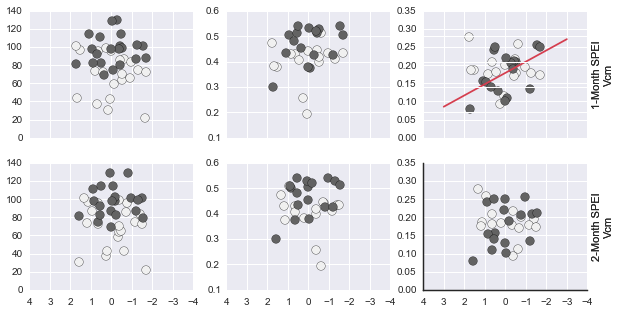

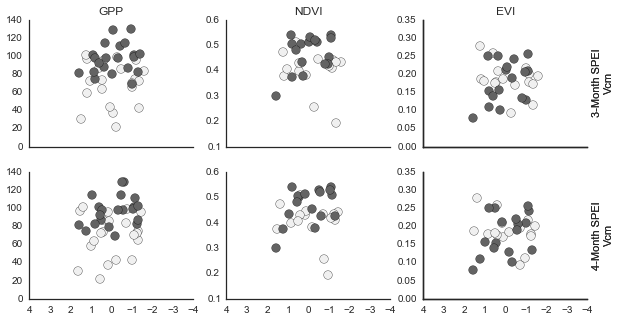

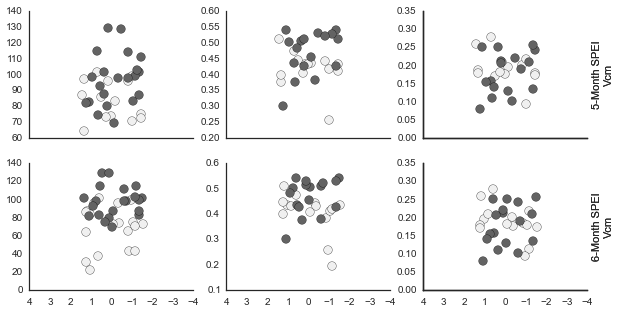

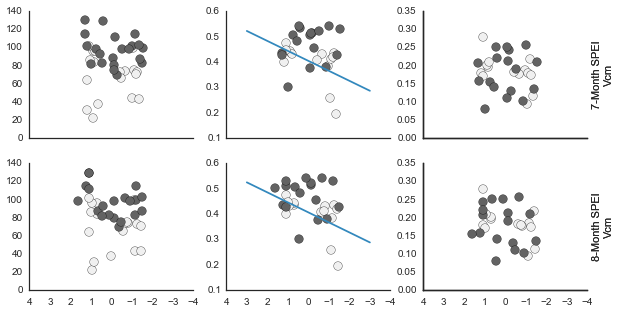

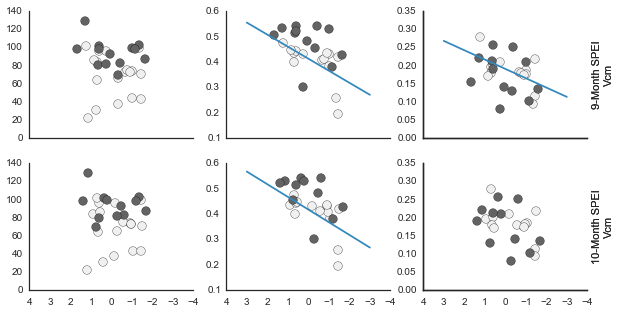

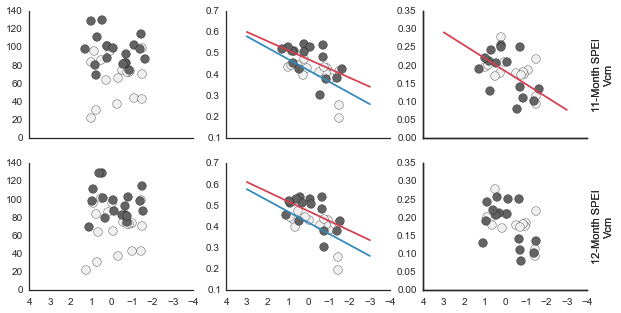

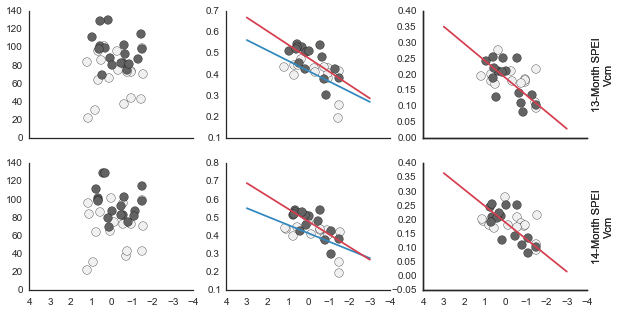

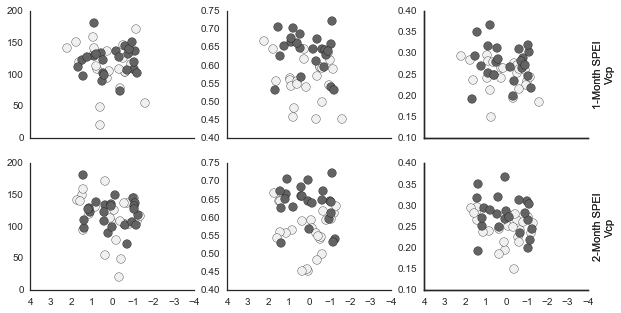

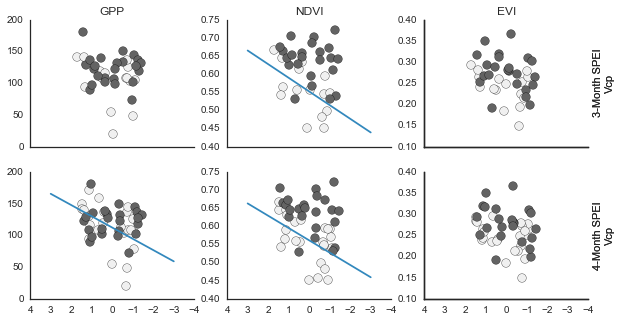

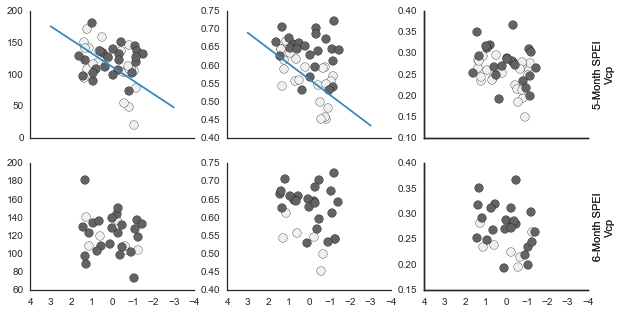

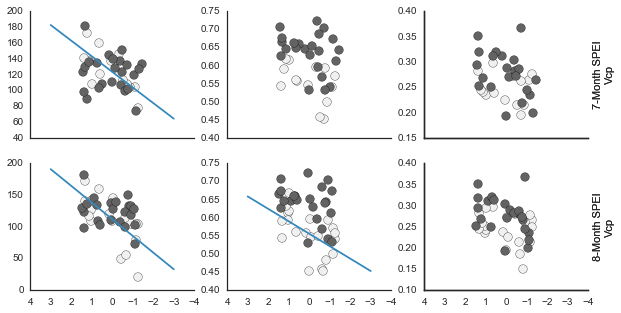

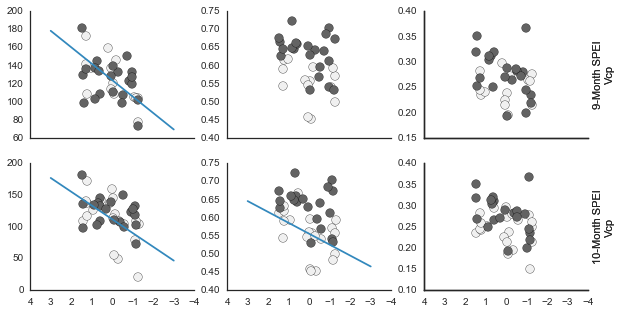

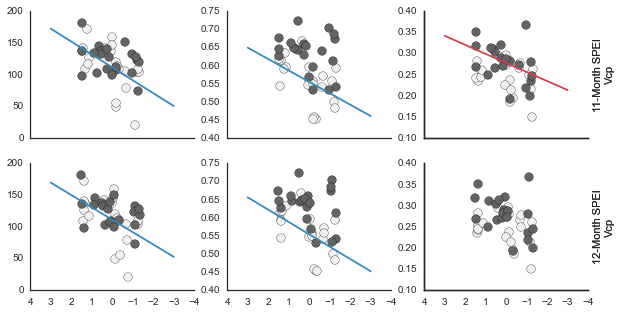

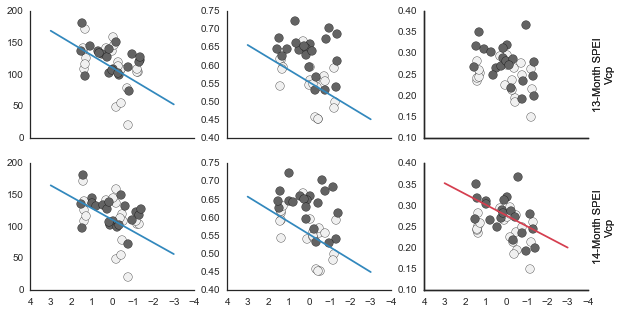

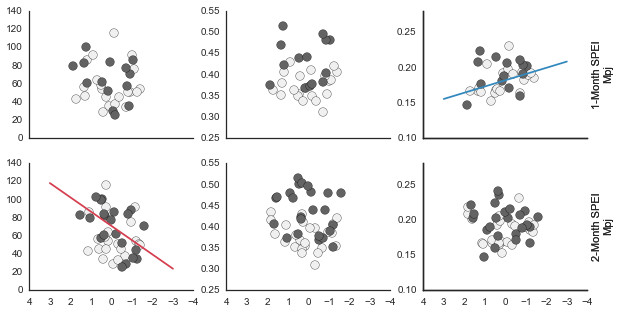

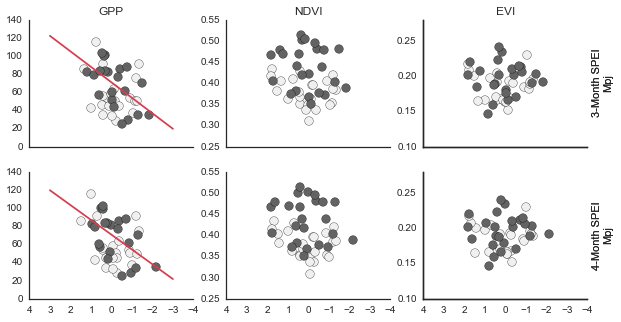

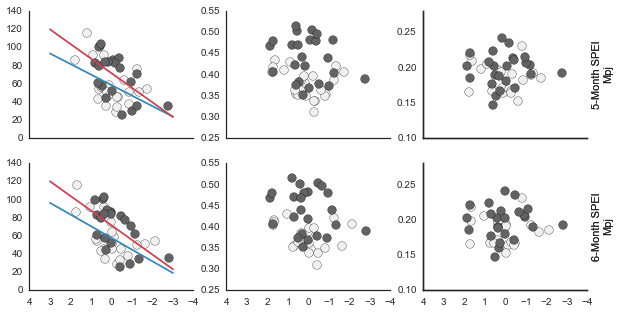

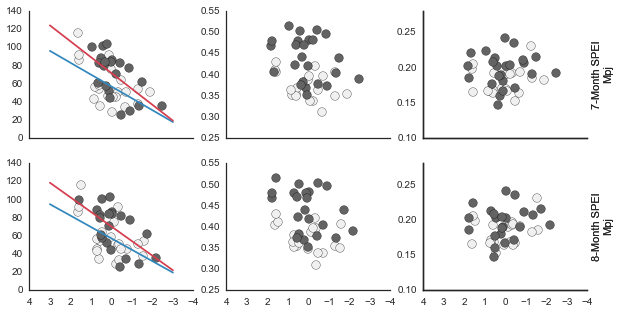

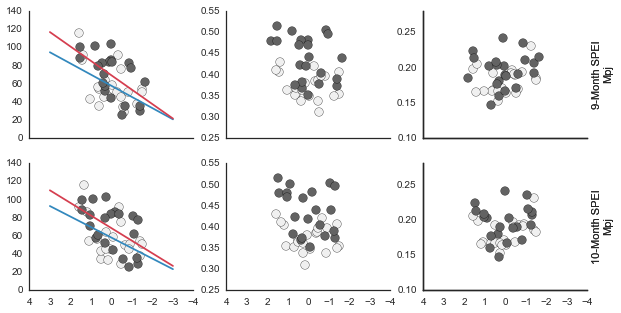

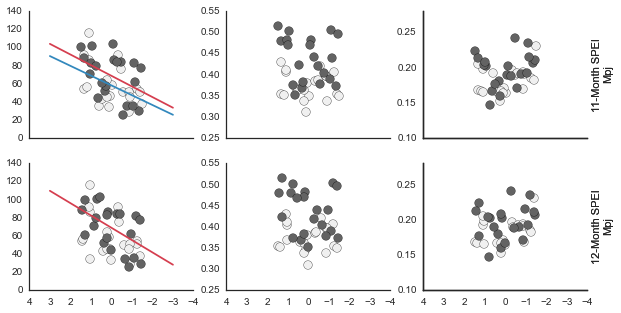

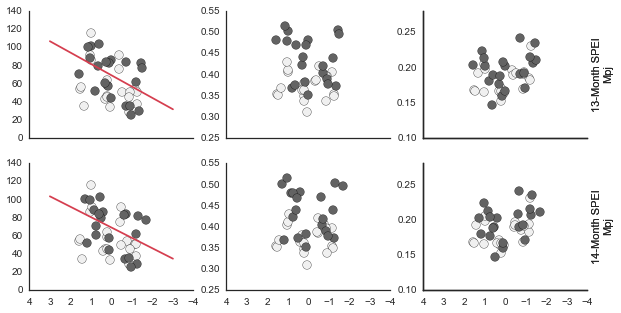

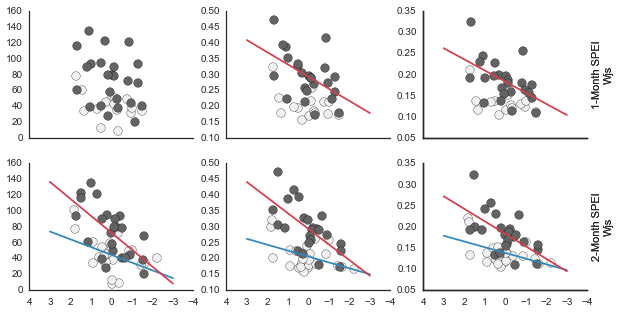

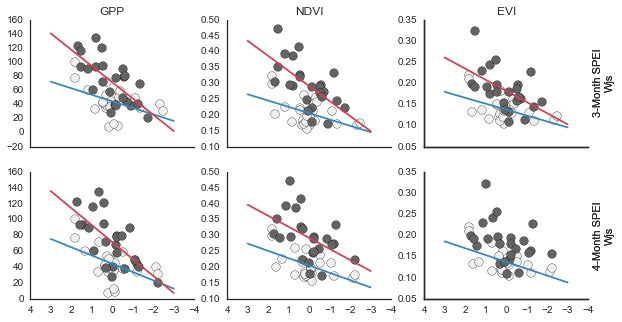

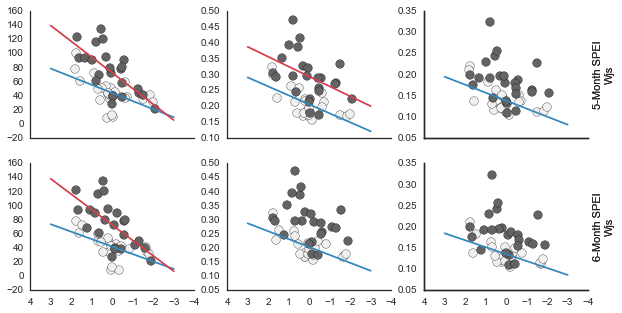

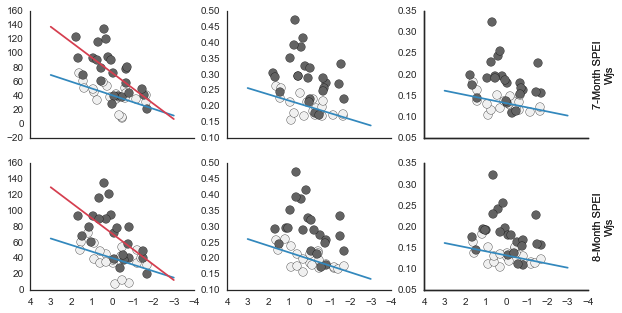

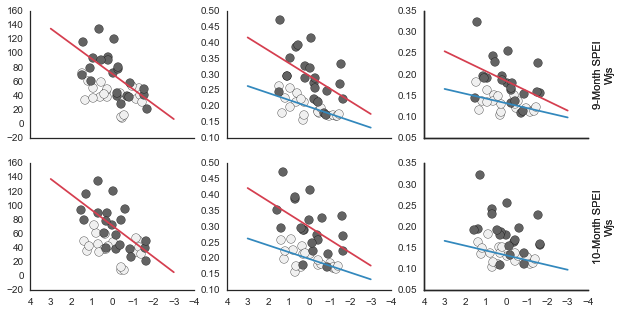

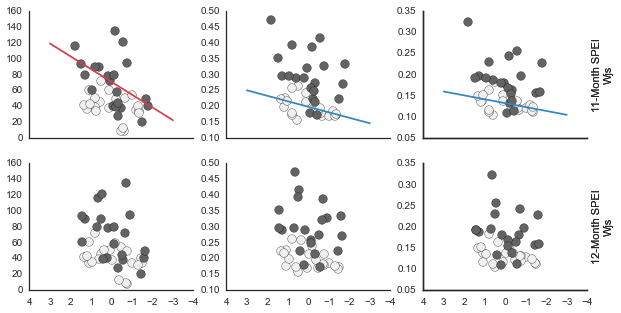

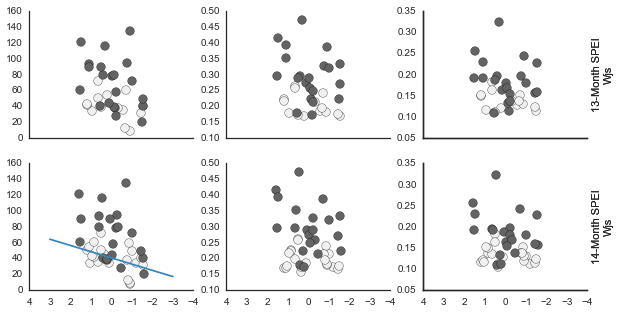

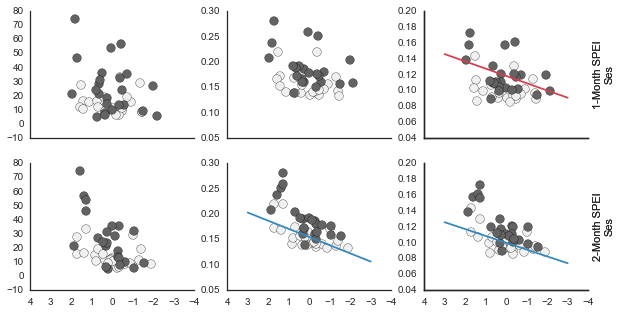

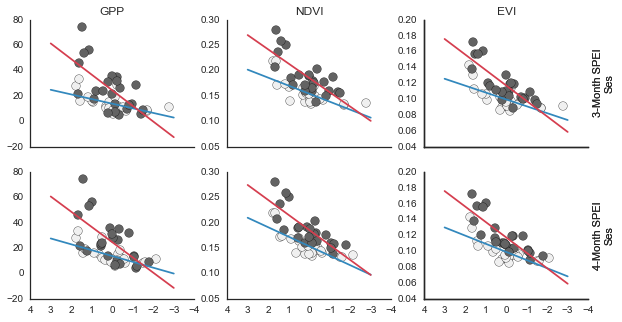

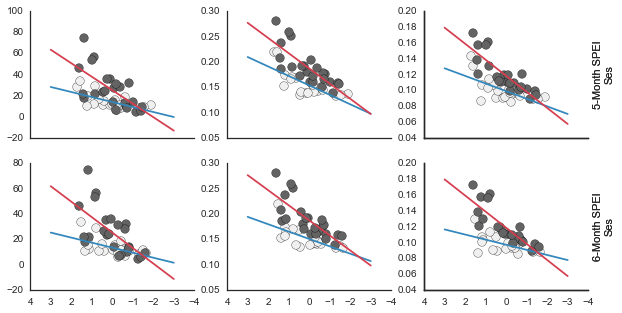

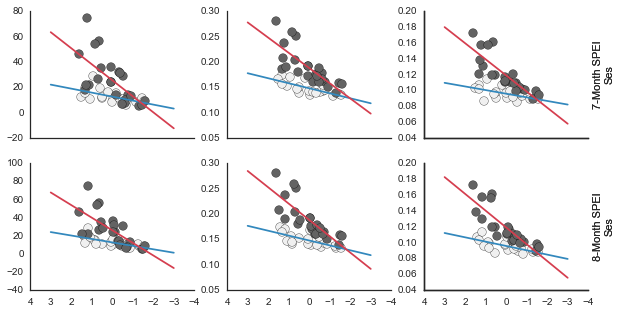

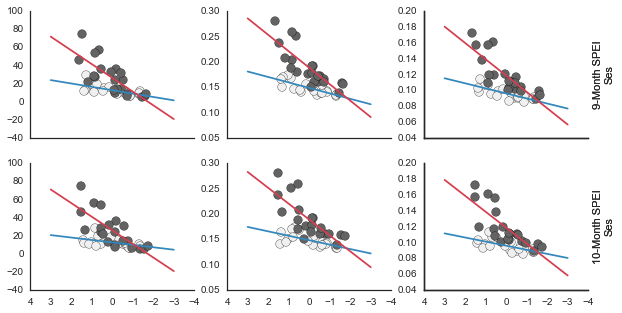

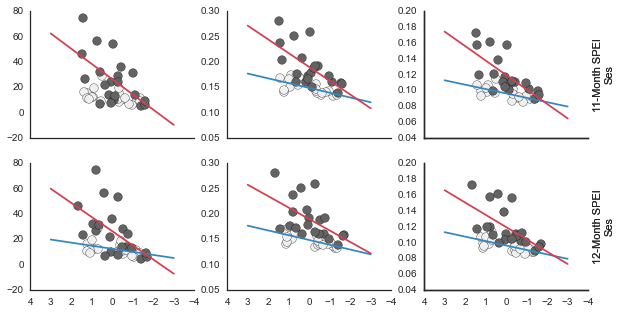

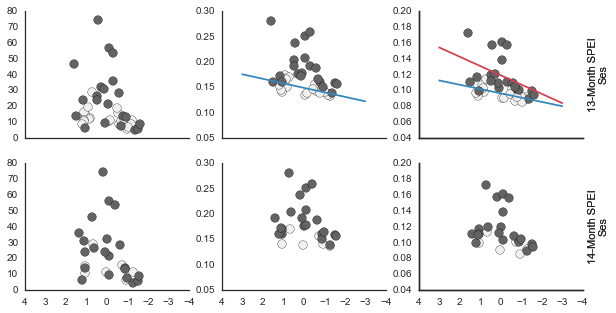

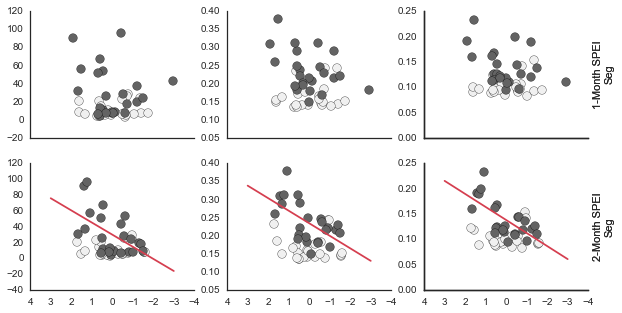

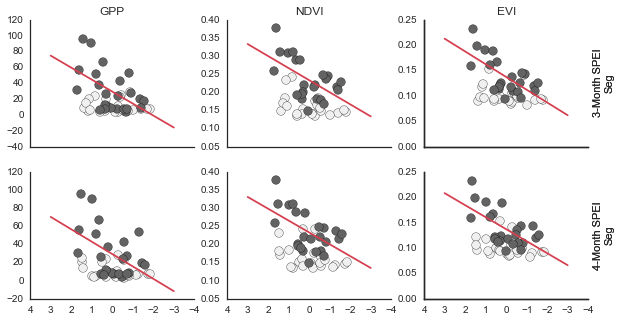

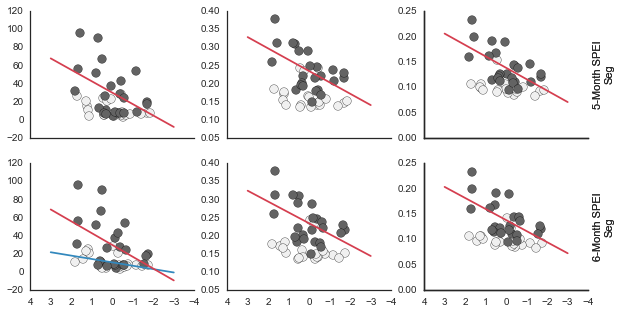

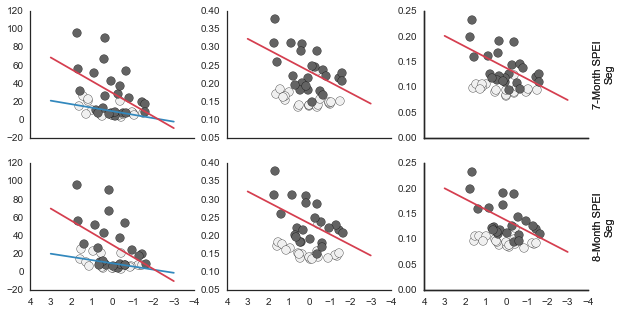

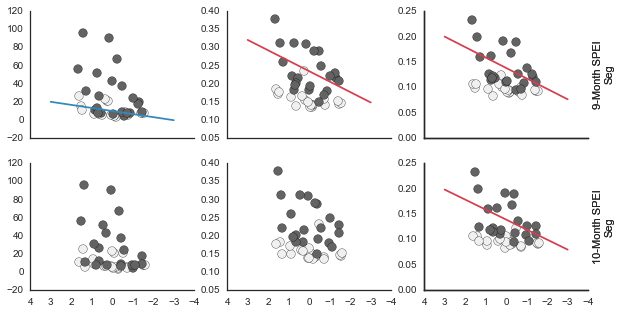

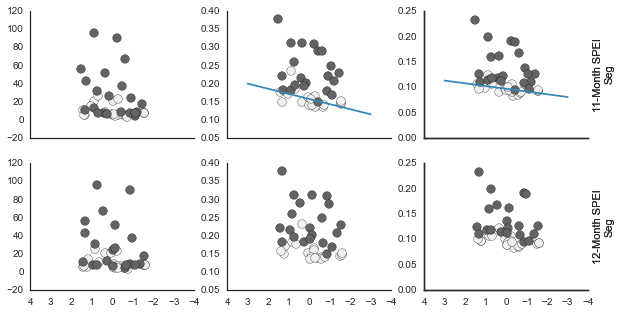

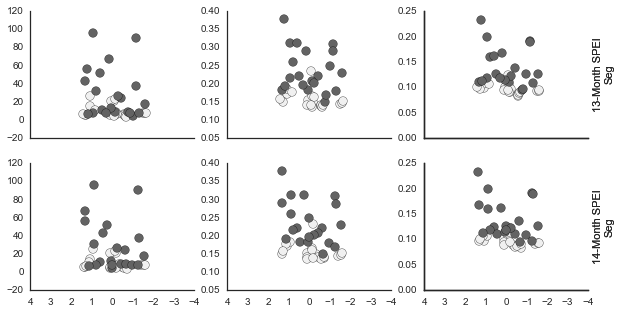

In [4]:
jet=plt.get_cmap('coolwarm')
sites = ['Vcm','Vcp','Mpj','Wjs','Ses','Seg']
idx = 0
linecols = ['#3288bd', '#d53e4f']
pointcols = ['#f0f0f0','#636363']
slopes = []
intercepts = []
thisvar = []
thissub = []
thismon = []
thissite = []
rsquares = []
for site in sites:
    mons = [1,2]
    for kki in np.arange(0,7,1):
        data = pd.read_csv(wrkDir + 'monthly_spei_flux_' + site + '.csv')
        cnames = data.columns.values 
        cnames[0] = 'Time'
        data.columns = cnames
        data.index = pd.to_datetime(data['Time'])
        # ------------ append NDVI and EVI columns -------------- #
        toAppend = MODIS_Monthly[MODIS_Monthly.Year > 2006]
        toAppend = toAppend[toAppend.Year < 2015]
        data = data[data.index.year < 2015]
        sitendvi = pd.DataFrame(dict(NDVI = toAppend[site]))
        sitendvi.index = data.index
        data['ndvi'] = sitendvi/10000

        toAppend = MODISEVI_Monthly[MODISEVI_Monthly.Year > 2006]
        toAppend = toAppend[toAppend.Year < 2015]
        data = data[data.index.year < 2015]
        siteevi = pd.DataFrame(dict(EVI = toAppend[site]))
        siteevi.index = data.index
        data['evi'] = siteevi/10000

        # ------------ Restrict months and years -- special for MCON FIRE ---- #
        if site == 'Vcm':
             data = data[data.index.year < 2014]
        data = data[(data.index.month > 3) & (data.index.month < 10)]
        aprmayjun = data[data.index.month < 7]
        julaugsep = data[data.index.month > 6]
        datasubs = [aprmayjun, julaugsep]
        # ------------ Plot scatters for SPEI by GPP, NDVI, and EVI ------ #
        fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, 
                                                               figsize=(10,5), sharex=True)
        plt.subplots_adjust(hspace = 0.2, wspace = 0.2)
        fignum = 0
        axs = fig.axes
        for mon in mons:
            ax = axs[fignum]
            spei = 'spei' + str(mon) + 'mon'
            setid = 0
            for subset in datasubs:
            # Linear fit ----------------------------------

                y = []
                toFit = pd.DataFrame(dict(spei = subset[spei].ravel(), gpp = subset.GPP_g_int.ravel()))
                ols = smf.ols('gpp ~ spei', data = toFit).fit()
                slope = (ols.params['spei'])
                intercept = (ols.params['Intercept'])
                # ----- Build dataframe stats ----- #
                thisvar.append('gpp')
                thissite.append(site)
                if setid == 0:
                    thissub.append('Spring')
                else:
                    thissub.append('Fall')
                thismon.append(mon)

                ax.scatter(subset[spei].ravel(), subset.GPP_g_int.ravel(), 
                   color = pointcols[setid], marker = 'o',  
                           edgecolor='k', s = 75)

                for num in np.arange(-3, 4, 1):
                    y.append(intercept + slope*num)
                if ols.pvalues[0] < 0.05:
                    if ols.pvalues[1] < 0.05:
                        ax.plot(np.arange(-3,4,1), y, color = linecols[setid])
                        slopes.append(slope)
                        intercepts.append(intercept)
                        rsquares.append(ols.rsquared_adj)
                    else:
                        slopes.append(np.nan)
                        intercepts.append(np.nan)
                        rsquares.append(np.nan)
                else:
                    slopes.append(np.nan)
                    intercepts.append(np.nan)
                    rsquares.append(np.nan)

                    

                ax.set_xlim(4, -4)
                setid = setid + 1

            setid = 0        
            for subset in datasubs:
            # Linear fit ----------------------------------
                y = []
                toFit = pd.DataFrame(dict(spei = subset[spei].ravel(), ndvi = subset.ndvi.ravel()))
                ols = smf.ols('ndvi ~ spei', data = toFit).fit()
                slope = (ols.params['spei'])
                intercept = (ols.params['Intercept'])
                # ----- Build dataframe stats ----- #
                thisvar.append('ndvi')
                thissite.append(site)
                if setid == 0:
                    thissub.append('Spring')
                else:
                    thissub.append('Fall')
                thismon.append(mon)

                axs[fignum + 1].scatter(subset[spei].ravel(), subset.ndvi.ravel(), 
                   color = pointcols[setid], marker = 'o',  
                           edgecolor='k', s = 75)

                for num in np.arange(-3, 4, 1):
                    y.append(intercept + slope*num)
                if ols.pvalues[0] < 0.05:
                    if ols.pvalues[1] < 0.05:
                        axs[fignum + 1].plot(np.arange(-3,4,1), y, color = linecols[setid])
                        slopes.append(slope)
                        intercepts.append(intercept)
                        rsquares.append(ols.rsquared_adj)
                    else:
                        slopes.append(np.nan)
                        intercepts.append(np.nan)
                        rsquares.append(np.nan)
                else:
                    slopes.append(np.nan)
                    intercepts.append(np.nan)
                    rsquares.append(np.nan)

                setid = setid + 1


            setid = 0
            for subset in datasubs:
            # Linear fit ----------------------------------
                y = []
                toFit = pd.DataFrame(dict(spei = subset[spei].ravel(), evi = subset.evi.ravel()))
                ols = smf.ols('evi ~ spei', data = toFit).fit()
                slope = (ols.params['spei'])
                intercept = (ols.params['Intercept'])
                # ----- Build dataframe stats ----- #
                thisvar.append('evi')
                thissite.append(site)
                if setid == 0:
                    thissub.append('Spring')
                else:
                    thissub.append('Fall')
                thismon.append(mon)

                axs[fignum + 2].scatter(subset[spei].ravel(), subset.evi.ravel(), 
                   color = pointcols[setid], marker = 'o',  
                           edgecolor='k', s = 75)

                for num in np.arange(-3, 4, 1):
                    y.append(intercept + slope*num)
                if ols.pvalues[0] < 0.05:
                    if ols.pvalues[1] < 0.05:
                        axs[fignum + 2].plot(np.arange(-3,4,1), y, color = linecols[setid])
                        slopes.append(slope)
                        intercepts.append(intercept)
                        rsquares.append(ols.rsquared_adj)
                    else:
                        slopes.append(np.nan)
                        intercepts.append(np.nan)
                        rsquares.append(np.nan)
                else:
                    slopes.append(np.nan)
                    intercepts.append(np.nan)
                    rsquares.append(np.nan)



                setid = setid + 1
                ax2 = axs[fignum + 2].twinx()
                ax2.set_ylabel(str(mon) + '-Month SPEI \n' + site)
                ax2.set_yticklabels('')

            # Fig aesthetics ------------------------------
            if mon == 3:
                ax.set_title('GPP')
                axs[fignum + 1].set_title('NDVI')
                axs[fignum + 2].set_title('EVI')
            fignum = fignum + 3

            sns.set_style('white')
            sns.despine()
        mons = [x+2 for x in mons]
    idx = idx + 1


In [5]:
linefits = pd.DataFrame(dict(SITE = thissite, VAR = thisvar, 
                  SEASON = thissub, SPEI = thismon, 
                  SLOPE = slopes,  INTERCEPT = intercepts,
                  RSQUARED = rsquares))


In [6]:
sites = ['Vcm','Vcp','Mpj','Wjs','Ses','Seg']
allvars = ['gpp','ndvi','evi']
seasons = ['Spring','Fall']
variables = []
diff = []
thissite = []
for site in sites:
    sitefit = linefits[linefits.SITE == site].dropna()
    for var in allvars:
        fallsub = sitefit[(sitefit.VAR == var) & (sitefit.SEASON == 'Fall') & (sitefit.SPEI == 3)]
        springsub = sitefit[(sitefit.VAR == var) & (sitefit.SEASON == 'Spring') & (sitefit.SPEI == 3)]
        
        diff.append(fallsub.SLOPE.ravel() - springsub.SLOPE.ravel())
        variables.append(var)
        thissite.append(site)
diffDF = pd.DataFrame(dict(SITE = thissite, VARS = variables, DIFFS = diff))
diffDF

,DIFFS,SITE,VARS
0,[],Vcm,gpp
1,[],Vcm,ndvi
2,[],Vcm,evi
3,[],Vcp,gpp
4,[],Vcp,ndvi
5,[],Vcp,evi
6,[],Mpj,gpp
7,[],Mpj,ndvi
8,[],Mpj,evi
9,[13.821212802],Wjs,gpp
